# Overview of the Baseline Models
## Fitted using all available baseline data

Prerequisites:
- numpy
- pandas
- scipy
- matplotlib
- sklearn>=1.0.2
- sktime==0.10.0
- xgboost>=1.5.0
- pygam>=0.8.0

In [1]:
# import statements
import numpy as np
import pandas as pd
import joblib
import sys
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# data
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def TSToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,0:4]).astype(int)
    return X, Y

tsnv_dataset = pd.read_pickle('../Dataset/baseline_dataset_tsnv_24.gz')
tsnv_dataset = separateDataset(tsnv_dataset, 0.9)
tsnv_test_X, tsnv_test_Y = TSToXY(tsnv_dataset["test"])
ts_dataset = pd.read_pickle('../Dataset/baseline_dataset_ts_24.gz')
ts_dataset = separateDataset(ts_dataset, 0.9)
ts_test_X, ts_test_Y = TSToXY(ts_dataset["test"])

Training set size: 36317; Dev set size: 4036; Testing set size: 4484
Training set size: 36686; Dev set size: 4077; Testing set size: 4530


In [3]:
# make calibration plots for class (label) 0 and 3
from sklearn.metrics import brier_score_loss
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.neural_network import MLPClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sktime.regression.interval_based import TimeSeriesForestRegressor

def calibration_plot(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y;
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")
    if isinstance(clf, MultiOutputRegressor) or isinstance(clf, TimeSeriesForestRegressor):
        all_preds = np.clip(clf.predict(dataset_X),0,1)
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    for i in range(4):
        if isinstance(clf, MultiOutputClassifier):
            preds = all_preds[i,:,1]
        else:            
            preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = all_preds
    preds = preds[0,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,0]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = all_preds
    preds = preds[3,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,3]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

In [4]:
# make predictions according to the given thresholds
from scipy.special import expit

def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    if isinstance(clf, MultiOutputClassifier):
        preds_probs = np.array(preds_probs)[:,:,1].T
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

def regression_label(regr, datasetX, thresholds):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = np.clip(regr.predict(datasetX),0,1)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [5]:
# metrics
from sklearn.metrics import classification_report

## Model 1: Tree-based
XGBoost Multioutput Classifier handles the problem as a multi-label classification. The dataset used is the TSNV variant. There is an extra trees classifier also suitable for direct strike cases, but it has only a near negligible advantage.

##### XGB Classifier

In [6]:
# imports
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import ExtraTreesClassifier

xgb_clf = joblib.load("./models/baseline_model_gscv_xgb_clf_2022-03-11 15-54.skl")
xgb_thresholds = [0.19491, 0.18867, 0.07011, 0.10758]
extra_trees_clf = joblib.load("./models/baseline_model_gscv_extra_trees_clf_2022-03-09 19-57.skl")
extra_trees_threshold = 0.32857

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Best Threshold=0.32857, F-Score=0.80519


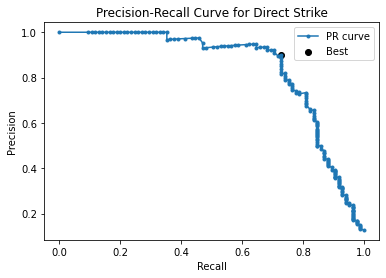

In [12]:
# check overfit and retrieve decision thresholds: the f1-scores and the PR curve should be very good for train but not so for dev/test
from sklearn.metrics import precision_recall_curve
tsnv_train_X, tsnv_train_Y = TSToXY(tsnv_dataset["dev"])
all_preds = extra_trees_clf.predict_proba(tsnv_train_X)
best_thresholds = []
best_f1_scores = []
# n_classes = 4
# all_preds = np.array(all_preds)[:,:,1].T
# for i in range(n_classes):
precision, recall, thresholds = precision_recall_curve(tsnv_train_Y[:,3], all_preds[:,1])
# find best threshold
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_thresholds.append(thresholds[ix])
best_f1_scores.append(fscore[ix])
print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

Brier score losses: (the smaller the better)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Class 0, no calibration: 0.017328
Class 1, no calibration: 0.015509
Class 2, no calibration: 0.008232
Class 3, no calibration: 0.009915


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


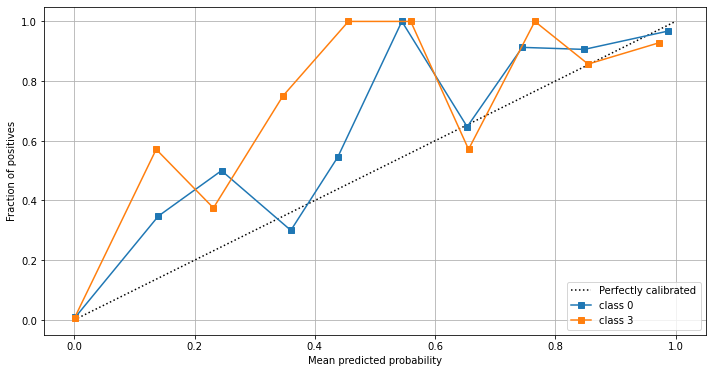

In [7]:
# only consider xgboost
calibration_plot(xgb_clf, tsnv_test_X, tsnv_test_Y)

In [8]:
preds = predictions_with_thresholds(xgb_clf, xgb_thresholds, tsnv_test_X)
print(classification_report(tsnv_test_Y, preds, zero_division=0, digits=5))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0    0.89086   0.86881   0.87970       404
           1    0.84226   0.88162   0.86149       321
           2    0.81356   0.82051   0.81702       117
           3    0.78571   0.62500   0.69620        88

   micro avg    0.85512   0.84409   0.84957       930
   macro avg    0.83310   0.79899   0.81360       930
weighted avg    0.85441   0.84409   0.84817       930
 samples avg    0.10086   0.10203   0.09949       930



##### XGB Regressor

In [6]:
# imports
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

xgb_regr = joblib.load("./models/baseline_model_gscv_xgb_regr_2022-04-15 21-31.skl")
xgb_thresholds = [0.37859, 0.40761, 0.26239, 0.32093]

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Brier score losses: (the smaller the better)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

Class 0, no calibration: 0.019226
Class 1, no calibration: 0.016786
Class 2, no calibration: 0.008796
Class 3, no calibration: 0.008980


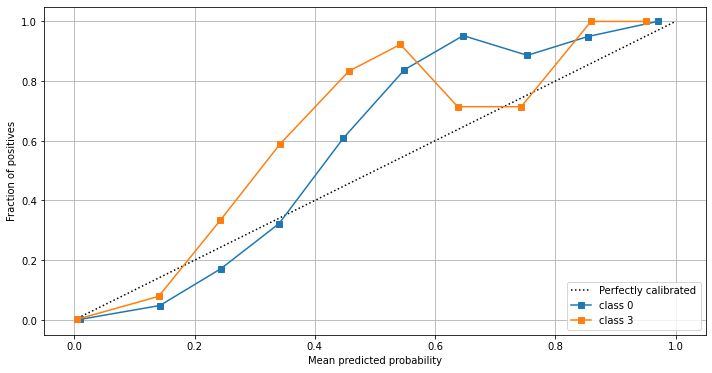

In [10]:
calibration_plot(xgb_regr, tsnv_test_X, tsnv_test_Y)

In [11]:
preds = regression_label(xgb_regr, tsnv_test_X, xgb_thresholds)
print(classification_report(tsnv_test_Y, preds, zero_division=0, digits=5))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

              precision    recall  f1-score   support

           0    0.88722   0.87624   0.88169       404
           1    0.85580   0.85047   0.85313       321
           2    0.78862   0.82906   0.80833       117
           3    0.84615   0.62500   0.71895        88

   micro avg    0.85982   0.83763   0.84858       930
   macro avg    0.84445   0.79519   0.81553       930
weighted avg    0.86008   0.83763   0.84720       930
 samples avg    0.10183   0.10179   0.09963       930



/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


##### ExtraTreesRegressor

In [12]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import ExtraTreesRegressor

extra_trees_regr = joblib.load("./models/baseline_model_gscv_extra_trees_regr_2022-04-15 21-47.skl")
extra_trees_thresholds = [0.31000, 0.42000, 0.26286, 0.26500]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.018574
Class 1, no calibration: 0.017315
Class 2, no calibration: 0.009701
Class 3, no calibration: 0.009789


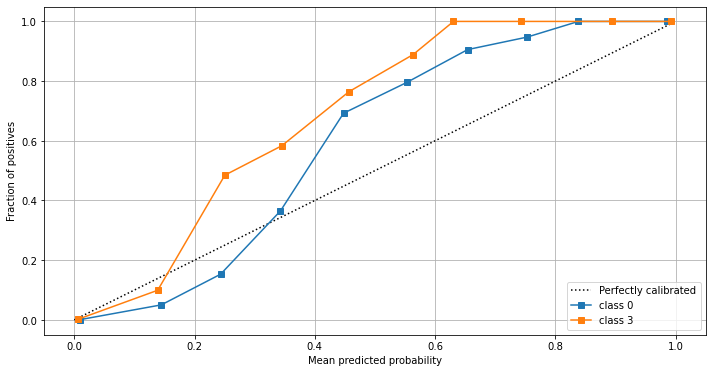

In [13]:
calibration_plot(extra_trees_regr, tsnv_test_X, tsnv_test_Y)

In [14]:
preds = regression_label(extra_trees_regr, tsnv_test_X, extra_trees_thresholds)
print(classification_report(tsnv_test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.84510   0.91832   0.88019       404
           1    0.87458   0.80374   0.83766       321
           2    0.75969   0.83761   0.79675       117
           3    0.75676   0.63636   0.69136        88

   micro avg    0.83565   0.84194   0.83878       930
   macro avg    0.80903   0.79901   0.80149       930
weighted avg    0.83617   0.84194   0.83715       930
 samples avg    0.10329   0.10279   0.10075       930



##### Use ExtraTreesClassifier for direct strike

In [9]:
# combine the two models into one
class CombinedTreeClassifier:
    def __init__(self, xgb, extra_trees):
        '''takes in a XGB classifier (1st-4th targets) and an extra trees classifier (4th target)'''
        self.xgb = xgb
        self.extra_trees = extra_trees
        self.classes_ = [2,2,2,2]
        
    def predict_proba(self, dataset_X):
        '''takes in an input dataset and returns the predicted probabilities in shape: (n_smaples, n_classes)'''
        xgb_preds = self.xgb.predict_proba(dataset_X)
        xgb_preds = np.array(xgb_preds)[:3,:,1]
        extra_trees_preds = self.extra_trees.predict_proba(dataset_X)[:,1].reshape(1,-2)
        return np.concatenate([xgb_preds, extra_trees_preds], axis=0).T
    
ctc_clf = CombinedTreeClassifier(xgb_clf, extra_trees_clf)

Brier score losses: (the smaller the better)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Class 0, no calibration: 0.017328
Class 1, no calibration: 0.015509
Class 2, no calibration: 0.008232
Class 3, no calibration: 0.009617


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


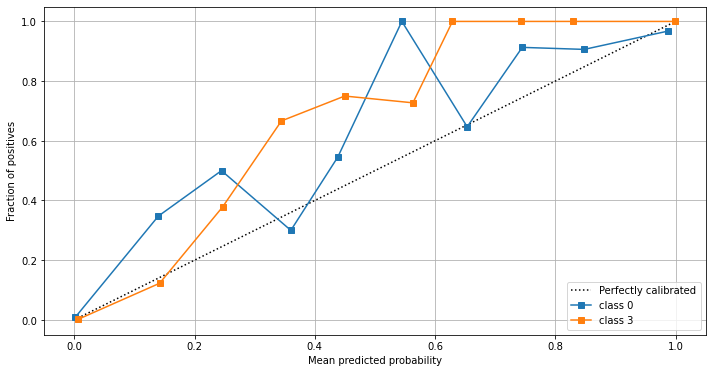

In [10]:
calibration_plot(ctc_clf, tsnv_test_X, tsnv_test_Y)

In [11]:
preds = predictions_with_thresholds(ctc_clf, [0.19491, 0.18867, 0.07011, 0.32857], tsnv_test_X)
print(classification_report(tsnv_test_Y, preds, zero_division=0, digits=5))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0    0.89086   0.86881   0.87970       404
           1    0.84226   0.88162   0.86149       321
           2    0.81356   0.82051   0.81702       117
           3    0.82258   0.57955   0.68000        88

   micro avg    0.85824   0.83978   0.84891       930
   macro avg    0.84232   0.78762   0.80955       930
weighted avg    0.85790   0.83978   0.84663       930
 samples avg    0.10116   0.10196   0.09955       930



## Model 2: Multilayer perceptron
Implemented with scikit-learn on the CPU. Hidden layers are (3072, 1024, 1024, 1024, 256); with batch size 512 and regularization 0.01. The dataset used is TSNV variant.  
The best decision thresholds are \[0.32311, 0.50209, 0.74931, 0.29005\], dev average f1 0.79509. Different randomization states may give different (ostensibly better) results, but for comparison purposes and to allow results be recreated, random states were fixed.     

MLP regressors: same structure, almost same loss at the end, score 0.53694.

There is some overfitting here, but smaller model complexities don't enhance performance. Regularization was strengthened but the difference was small.

In [6]:
from sklearn.neural_network import MLPClassifier

mlp_clf = joblib.load("./models/baseline_model_mlpclf_2022-04-16 21-09.skl")
mlp_clf_thresholds = [0.32311, 0.50209, 0.74931, 0.29005]

Best Threshold=0.32424, F-Score=0.95423
Best Threshold=0.32056, F-Score=0.95970
Best Threshold=0.66172, F-Score=0.96447
Best Threshold=0.49176, F-Score=0.96662


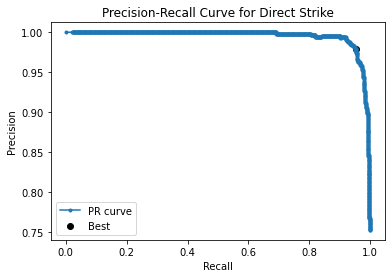

In [7]:
# check overfit: the f1-scores and the PR curve should be very good for train but not so for dev/test
from sklearn.metrics import precision_recall_curve
tsnv_train_X, tsnv_train_Y = TSToXY(tsnv_dataset["train"])
all_preds = mlp_clf.predict_proba(tsnv_train_X)
best_thresholds = []
best_f1_scores = []
n_classes = 4
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(tsnv_train_Y[:,i], all_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.026434
Class 1, no calibration: 0.020830
Class 2, no calibration: 0.012468
Class 3, no calibration: 0.010621


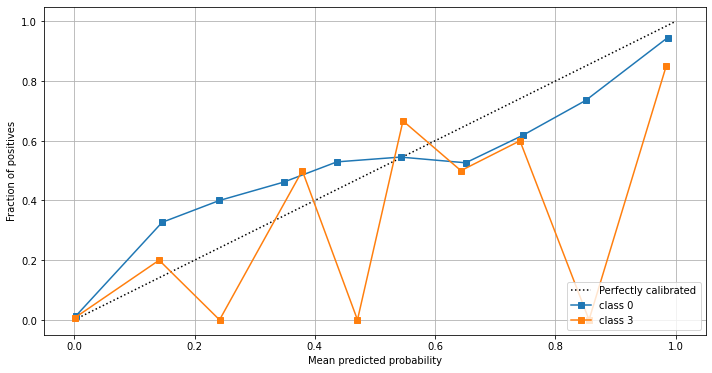

In [8]:
calibration_plot(mlp_clf, tsnv_test_X, tsnv_test_Y)

In [9]:
preds = predictions_with_thresholds(mlp_clf, mlp_clf_thresholds, tsnv_test_X)
print(classification_report(tsnv_test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.83641   0.78465   0.80971       404
           1    0.84000   0.78505   0.81159       321
           2    0.76596   0.61538   0.68246       117
           3    0.70513   0.62500   0.66265        88

   micro avg    0.81786   0.74839   0.78158       930
   macro avg    0.78687   0.70252   0.74160       930
weighted avg    0.81636   0.74839   0.78044       930
 samples avg    0.09285   0.08917   0.08893       930



## Model 3: Time Series Forest Classifier
Implemented with sktime with hyperparameters (min_interval=3, n_estimators=500) on the TS variant (not TSNV).  
The best decision thresholds are \[0.31213 0.27000 0.23604 0.25600\].

This also overfitted on the train set, and due to cross-validation difficulties further confirmation that 500 estimators isn't the best is so far intractable.

#### Classifier

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sktime.classification.interval_based import TimeSeriesForestClassifier

tsfs_clf = joblib.load("./models/baseline_model_tsfs_clf_2022-03-04 15-28.skl")
tsfs_clf_thresholds = [0.31213, 0.27000, 0.23604, 0.25600]

In [11]:
# special data preprocessing for sktime
from sktime.transformations.panel.compose import ColumnConcatenator
PAST_TRACK_LIMIT = 24

def convert_X(dataset_X):
    '''Takes in a (n_samples, n_features) Pandas dataframe and returns it in shape (n_samples, n_features, time_series_length)'''
    processed_samples = 0
    new_dataset = []
    for index, row in dataset_X.iterrows():
        new_row = []

        # obtain time series for each feature        
        for i in range(10): # 10 for baseline_dataset_ts_24, 12 for tsnv
            feature_name = dataset_X.columns[i][:-2]
            feature_series = []
            for j in range(0, PAST_TRACK_LIMIT+6, 6):        
                feature_series.append(row.loc["{0}{1:02d}".format(feature_name, j)]) # access by column name
            feature_series.reverse() # newest data come last
            feature_series = pd.Series(data=feature_series) # correct type for each cell
            new_row.append(feature_series)

        # new_row = pd.Series(data=new_row, index=new_features)
        new_dataset.append(new_row)
        processed_samples += 1

        if processed_samples % 1000 == 0:
            print("Finished concatenating {0}/{1} samples...".format(processed_samples, dataset_X.shape[0]))

    # get new column names
    new_features = []
    for i in range(10):
            feature_name = dataset_X.columns[i][:-2]
            new_features.append(feature_name)
            
    # convert types back
    # converted_X = pd.DataFrame(new_dataset, columns=new_features)
    converted_X = np.array(new_dataset)
    print("Completed")
    return converted_X

concat_test_X = convert_X(ts_test_X)
print("Before transform:", concat_test_X.shape)
concat_test_X = ColumnConcatenator().fit_transform(concat_test_X)
print("After transform:", concat_test_X.shape)
print("Each element is:", concat_test_X.iloc[0].iloc[0].shape)

Finished concatenating 1000/4484 samples...
Finished concatenating 2000/4484 samples...
Finished concatenating 3000/4484 samples...
Finished concatenating 4000/4484 samples...
Completed
Before transform: (4484, 12, 5)
After transform: (4484, 1)
Each element is: (60,)


Brier score losses: (the smaller the better)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd

Class 0, no calibration: 0.035992
Class 1, no calibration: 0.028371
Class 2, no calibration: 0.014414
Class 3, no calibration: 0.010481


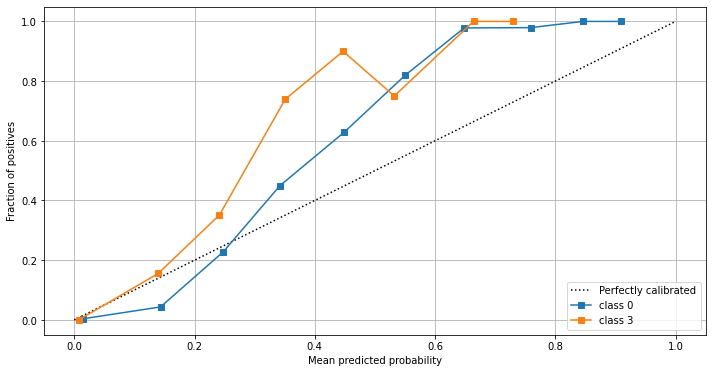

In [17]:
calibration_plot(tsfs_clf, concat_test_X, ts_test_Y)

In [18]:
preds = predictions_with_thresholds(tsfs_clf, tsfs_clf_thresholds, concat_test_X)
print(classification_report(ts_test_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.73034   0.77197   0.75058       421
           1    0.68957   0.83621   0.75584       348
           2    0.67742   0.77778   0.72414       135
           3    0.75362   0.61905   0.67974        84

   micro avg    0.70852   0.78239   0.74363       988
   macro avg    0.71274   0.75125   0.72757       988
weighted avg    0.71073   0.78239   0.74280       988
 samples avg    0.08861   0.09593   0.08935       988



#### Regressor (TSNV)

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sktime.regression.interval_based import TimeSeriesForestRegressor

tsfs_regr = joblib.load("./models/baseline_model_tsnv_tsfs_regr_2022-04-16 16-50.skl")
tsfs_regr_thresholds = [0.36714, 0.36000, 0.34000, 0.26429]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.040498
Class 1, no calibration: 0.030900
Class 2, no calibration: 0.014717
Class 3, no calibration: 0.013808


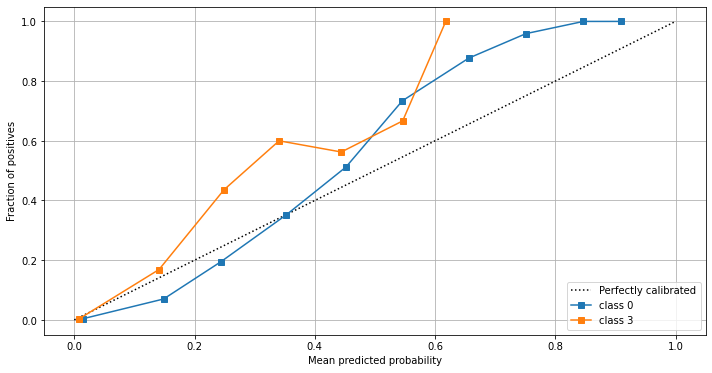

In [15]:
calibration_plot(tsfs_regr, concat_test_X, tsnv_test_Y)

In [13]:
preds = regression_label(tsfs_regr, concat_test_X, tsfs_regr_thresholds)
print(classification_report(tsnv_test_Y, preds, zero_division=0, digits=5))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Ind

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_panel/_check.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_panel/_check.py:49: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (pd.Int64Index, pd.RangeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd

              precision    recall  f1-score   support

           0    0.67619   0.70297   0.68932       404
           1    0.70755   0.70093   0.70423       321
           2    0.75904   0.53846   0.63000       117
           3    0.60345   0.39773   0.47945        88

   micro avg    0.69056   0.65269   0.67109       930
   macro avg    0.68656   0.58502   0.62575       930
weighted avg    0.69055   0.65269   0.66714       930
 samples avg    0.08051   0.08097   0.07776       930



## Model 4: TSNV GAM
GAM model on the TSNV dataset. Four separate GAMs were built for each target predictand, so the code needs to be custom-adjusted below.  
Best thresholds \[0.59373, 0.58287, 0.57836, 0.57504\].

The calibration is rather bad, and the scores (average 0.60686/0.60176) are by far the worst. There is some moderate over-fitting for each class. 

In [6]:
import pickle as pk

file = open("./models/baseline_model_gam_tsnv_2022-04-08 17-43.pkl", "rb") 
gam = pk.load(file)
file.close()
gam_thresholds = [0.59373, 0.58287, 0.57836, 0.57504]

(36317, 4)
Best Threshold=0.38627, F-Score=0.82412
Best Threshold=0.31466, F-Score=0.77285
Best Threshold=0.23762, F-Score=0.66285
Best Threshold=0.32882, F-Score=0.60755


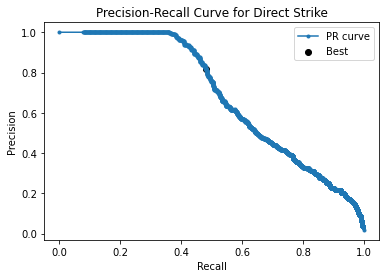

In [7]:
# check overfitting
from sklearn.metrics import precision_recall_curve
tsnv_train_X, tsnv_train_Y = TSToXY(tsnv_dataset["train"])

# generate predictions
raw_preds = []
for i in range(4):
    tr_dev_X = gam["fs"][i].transform(gam["poly"].transform(tsnv_train_X.iloc[:,:13]))
    preds = np.clip(gam["gam"][i].predict(tr_dev_X), 0, 1) #expit(gam["gam"][i].predict(tr_dev_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

# find thresholds
best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(tsnv_train_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

(4484, 4)
Brier score losses: (the smaller the better)
Class 0, no calibration: 0.038443
Class 1, no calibration: 0.027707
Class 2, no calibration: 0.013784
Class 3, no calibration: 0.014759


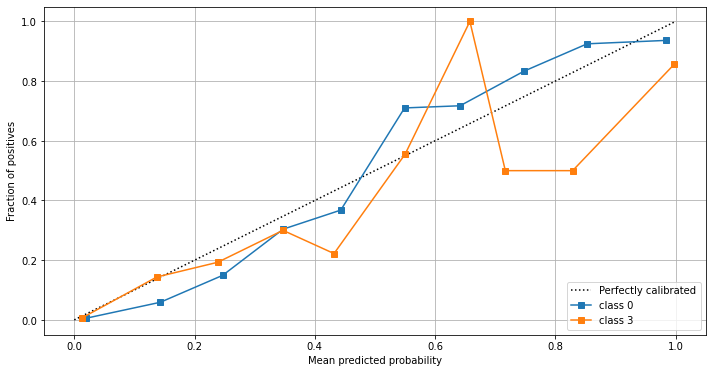

In [8]:
# generate predictions
raw_preds = []
for i in range(4):
    tr_test_X = gam["fs"][i].transform(gam["poly"].transform(tsnv_test_X.iloc[:,:13]))
    preds = np.clip(gam["gam"][i].predict(tr_test_X),0,1) #expit(gam["gam"][i].predict(tr_test_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

# brier score loss
print("Brier score losses: (the smaller the better)")    
for i in range(4):
    preds = raw_preds[:,i]
    clf_score = brier_score_loss(tsnv_test_Y[:,i], preds)
    print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

# plot calibration graphs
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
ax = fig.add_subplot(gs[:2, :2])

preds = raw_preds[:,0]
display = CalibrationDisplay.from_predictions(tsnv_test_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
preds = raw_preds[:,3]
display = CalibrationDisplay.from_predictions(tsnv_test_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

ax.grid()
plt.tight_layout()
plt.show()

(4036, 4)
Best Threshold=0.37940, F-Score=0.73786
Best Threshold=0.33457, F-Score=0.72109
Best Threshold=0.31605, F-Score=0.62312
Best Threshold=0.30244, F-Score=0.52980
(4484, 4)
              precision    recall  f1-score   support

           0    0.70270   0.70792   0.70530       404
           1    0.71865   0.73209   0.72531       321
           2    0.72941   0.52991   0.61386       117
           3    0.50943   0.30682   0.38298        88

   micro avg    0.69954   0.65591   0.67703       930
   macro avg    0.66505   0.56919   0.60686       930
weighted avg    0.69328   0.65591   0.67020       930
 samples avg    0.07794   0.08069   0.07608       930



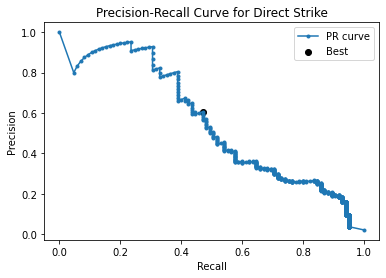

In [11]:
# check overfitting
from sklearn.metrics import precision_recall_curve
tsnv_dev_X, tsnv_dev_Y = TSToXY(tsnv_dataset["dev"])

# generate predictions
raw_preds = []
for i in range(4):
    tr_dev_X = gam["fs"][i].transform(gam["poly"].transform(tsnv_dev_X.iloc[:,:13]))
    preds = np.clip(gam["gam"][i].predict(tr_dev_X), 0, 1) #expit(gam["gam"][i].predict(tr_dev_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

# find thresholds
best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(tsnv_dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

# generate predictions
raw_preds = []
for i in range(4):
    tr_test_X = gam["fs"][i].transform(gam["poly"].transform(tsnv_test_X.iloc[:,:13]))
    preds = np.clip(gam["gam"][i].predict(tr_test_X), 0, 1) #expit(gam["gam"][i].predict(tr_dev_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

# generate deterministic
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(tsnv_test_Y, preds, digits=5, zero_division=0))

In [9]:
# generate deterministic
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(tsnv_test_Y, preds, digits=5, zero_division=0))

              precision    recall  f1-score   support

           0    0.71392   0.69802   0.70588       404
           1    0.68946   0.75389   0.72024       321
           2    0.59322   0.59829   0.59574       117
           3    0.55319   0.29545   0.38519        88

   micro avg    0.68057   0.66667   0.67355       930
   macro avg    0.63745   0.58641   0.60176       930
weighted avg    0.67509   0.66667   0.66664       930
 samples avg    0.07525   0.08107   0.07487       930

